# House price with NN

#### Libraries

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import tensorflow as tf
print("TensorFlow version:", tf.__version__)


import xgboost as xgb



#### Common config 

In [ ]:
PATH_RAW_DATA = "../data/raw/"
PATH_PROCESSED_DATA = "../data/processed/"
PATH_FINAL_DATA = "../data/final/"


#### Upload raw data from folder
the _updated file has also latidute and longitude otherwise is identical

In [ ]:
# set id as index
df = pd.read_csv(PATH_RAW_DATA + 'housing_data_italy_august2022.csv').set_index('id')
df

### Data Cleaning

In [ ]:
# drop columns not interesting
df.drop('timestamp', axis=1, inplace=True)
df.drop('availability', axis=1, inplace=True)
df.drop('status', axis=1, inplace=True)


#drop rows with na
print(f"{len(df)}")
df.dropna(inplace=True)
print(f"{len(df)}")

In [ ]:
df['year_of_construction']= pd.to_datetime(df['year_of_construction'], format='%Y', errors='ignore')
df

In [ ]:
df.columns

In [ ]:
# eliminate outliers of price
first_qrt = np.quantile(df['price'], 0.25)
third_qrt = np.quantile(df['price'], 0.75)

price_out_range_up = df['price'][(df['price'] > third_qrt + (third_qrt-first_qrt)*1.5)]
price_out_range_down = df['price'][(df['price'] < first_qrt - (third_qrt-first_qrt)*1.5)]
df.drop(price_out_range_up.index, inplace=True)
df.drop(price_out_range_down.index, inplace=True)
df

In [ ]:
# eliminate future dates in year_of_construction year 2022 max
df.drop(df[df['year_of_construction']>2022].index, inplace=True)


In [ ]:
# eliminate n_rooms or mq or n_bathrooms with zero
df.drop(df[df['n_rooms']==0].index, inplace=True)
df.drop(df[df['mq']==0].index, inplace=True)
df.drop(df[df['n_bathrooms']==0].index, inplace=True)

### Data Visualization

In [ ]:
df['n_bathrooms'] = df['n_bathrooms'].astype(int)
df['n_rooms'] = df['n_rooms'].astype(int)

columns_list=['n_rooms', 'floor', 'mq', 'n_bathrooms', 'energy_class', 
        'heating','has_garage', 'has_terrace', 'has_garden',
        'has_balcony', 'has_fireplace',
       'has_alarm', 'has_air_conditioning', 'has_pool', 'has_parking',
       'has_elevator', 'is_furnished']

for col in columns_list:
    print(f"{col:22} with {df[col].nunique():7} unique values, has type {df[col].dtype}")
    if len(df[col].unique()) < 15:
        fig=px.histogram(df[col].sort_values())
        fig.update_xaxes(type='category')
        fig.show()
    else:
        px.histogram(df[col]).show()

print(f"{'year_of_construction':22} with {df['year_of_construction'].nunique():7} unique values, has type {df['year_of_construction'].dtype}")
px.histogram(df['year_of_construction'])

# modeling

#### prepare data

In [33]:
one_hot_encoded_data = pd.get_dummies(df, columns=['energy_class', 'heating']).drop(['location', 'title'], axis=1)
one_hot_encoded_data = one_hot_encoded_data.astype(int)
X = one_hot_encoded_data.drop(['price'], axis=1).values
y = one_hot_encoded_data['price'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [42]:
results_df = {}

## Linear regression

In [46]:
model = LinearRegression().fit(X_train,y_train)
r_sq = model.score(X_train, y_train)
print(f"coefficient of determination: {r_sq}")
#print(f"intercept: {model.intercept_}")
#print(f"coefficients: {model.coef_}")
y_pred = model.predict(X_test)
MSE = round(mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False), 2)
print(f"MSE : {MSE}")
results_df['linear_regression'] = (MSE, r_sq)
fig = px.scatter(x=y_test, y=y_pred, labels={'x': 'ground truth', 'y': 'prediction'})
fig.add_shape(
    type="line", line=dict(dash='dash'),
    x0=y_test.min(), y0=y_test.min(),
    x1=y_test.max(), y1=y_test.max()
)
fig.show()


coefficient of determination: 0.2635170983006153
MSE : 68153.55


## decision tree

In [47]:
model = tree.DecisionTreeRegressor().fit(X_train, y_train)
r_sq = model.score(X_train, y_train)
print(f"coefficient of determination: {r_sq}")
y_pred = model.predict(X_test)
MSE = round(mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False), 2)
print(f"MSE : {MSE}")
results_df['decision_tree'] = (MSE, r_sq)

fig = px.scatter(x=y_test, y=y_pred, labels={'x': 'ground truth', 'y': 'prediction'})
fig.add_shape(
    type="line", line=dict(dash='dash'),
    x0=y_test.min(), y0=y_test.min(),
    x1=y_test.max(), y1=y_test.max()
)
fig.show()



coefficient of determination: 0.9672658393594082
MSE : 91290.48


In [48]:
model = RandomForestRegressor(max_depth=150, random_state=42).fit(X_train, y_train)
r_sq = model.score(X_train, y_train)
print(f"coefficient of determination: {r_sq}")
y_pred = model.predict(X_test)
MSE = round(mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False), 2)
print(f"MSE : {MSE}")
results_df['random_forest150'] = (MSE, r_sq)

fig = px.scatter(x=y_test, y=y_pred, labels={'x': 'ground truth', 'y': 'prediction'})
fig.add_shape(
    type="line", line=dict(dash='dash'),
    x0=y_test.min(), y0=y_test.min(),
    x1=y_test.max(), y1=y_test.max()
)
fig.show()

coefficient of determination: 0.8734214280955226
MSE : 67851.3


#### XGboost

In [56]:
# evaluate xgboost ensemble for regression
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

In [62]:
model = xgb.XGBRegressor()
# evaluate the model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('rmse: %.3f (%.3f)' % ((mean(n_scores))*-1, std(n_scores)))

rmse: 4195618020.713 (96092174.033)


In [54]:
model = xgb.XGBRegressor()

eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=eval_set)

y_pred = model.predict(X_test)

predictions = [round(value) for value in y_pred]

xgb.plot_importance(model)

rmse = round(mean_squared_error(y_test, predictions, squared=False),2)
print(f"RMSE: {rmse}")
results_df['XGBoostKfold'] = (rmse, 0)

Mean MAE: 49184.251 (344.350)


NotFittedError: need to call fit or load_model beforehand

In [50]:

# Crea oggetti DMatrix per set di addestramento e test
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'max_depth': 5,
    'eta': 0.01,
    'objective': 'reg:squarederror',  # per problemi di regressione
    'eval_metric': 'rmse'  # metrica di valutazione (Root Mean Squared Error)
}

num_rounds = 550  # Numero di iterazioni di boosting

# Addestra il modello
model = xgb.train(params, dtrain, num_rounds)

# Effettua previsioni sul set di test
predictions = model.predict(dtest)


rmse = round(mean_squared_error(y_test, predictions, squared=False),2)
print(f"RMSE: {rmse}")
results_df['XGBoost1'] = (rmse, 0)



RMSE: 64710.92


## neural network

##### perceptron

In [ ]:
# Definisci il modello
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(X_train.shape[1],)),  # Input layer
    tf.keras.layers.Dense(1)  # Single dense layer with sigmoid activation
])

# Compila il modello
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

# Addestra il modello
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(X_train.shape[1],)),
    # Hidden layers
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),

    # Output layer
    tf.keras.layers.Dense(1)  # Output layer senza funzione di attivazione per la regressione

])

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_squared_error', 'mean_absolute_error']
)

history = model.fit(X_train, y_train, epochs=300, batch_size=1000, validation_data=(X_test, y_test))
y_pred = model.predict(X_test)
y_pred

In [ ]:
# Stampa la storia dell'addestramento
print(history.history.keys())

# Plot della loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot della loss
plt.plot(history.history['mean_absolute_error'], label='mean_absolute_error')
plt.plot(history.history['val_mean_absolute_error'], label='val_mean_absolute_error')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

results_df['NN7layer']= (history.history['mean_squared_error'][-1], 0)


In [ ]:
results_df

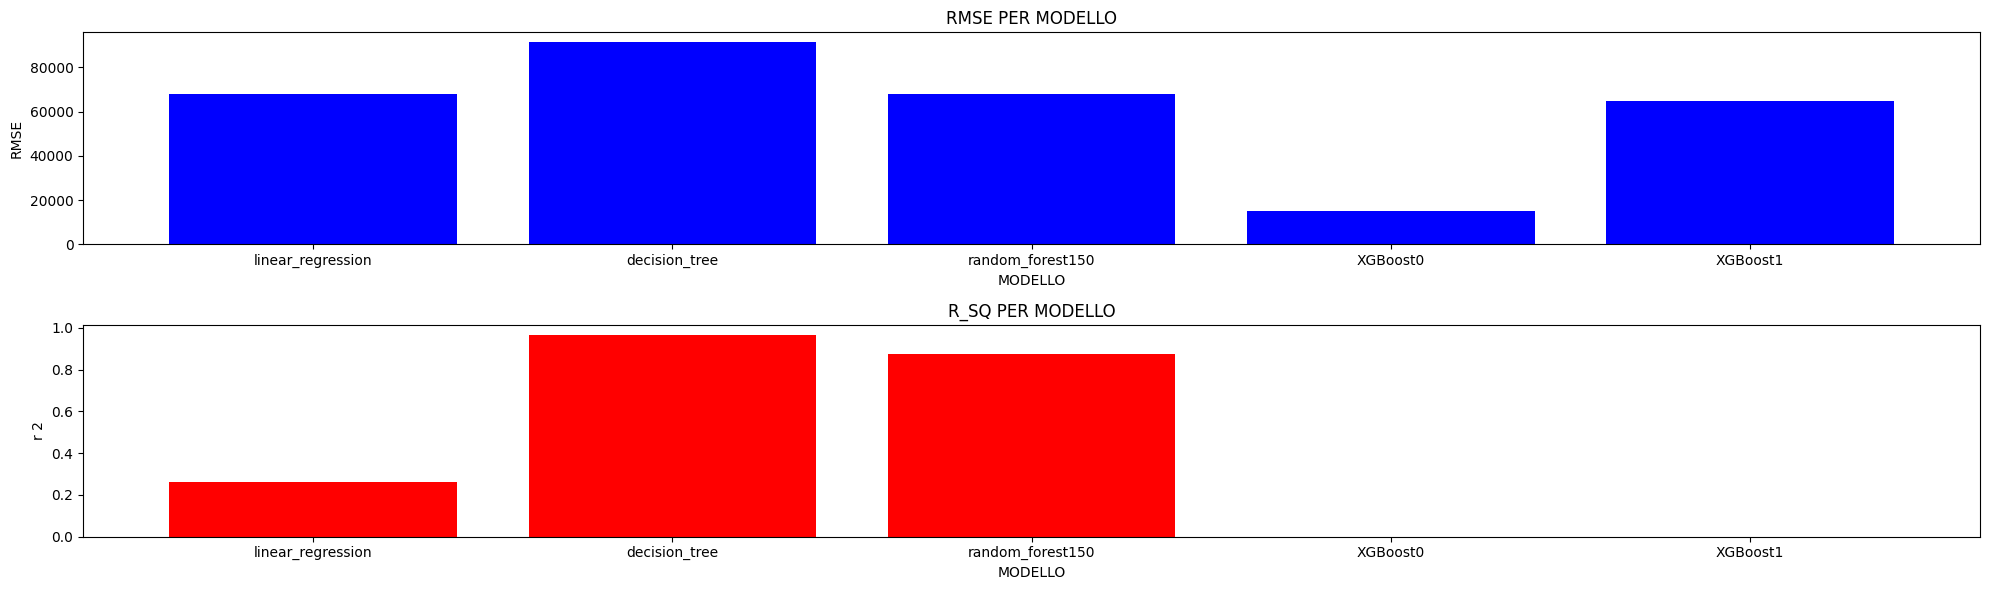

In [51]:
# Estrai le chiavi e i valori dal dizionario
chiavi = results_df.keys()
valori_mse = [val[0] for val in results_df.values()]
valori_r_sq = [val[1] for val in results_df.values()]

# Crea i due subplot
fig, axs = plt.subplots(2, 1, figsize=(20, 6))

# Primo grafico
axs[0].bar(chiavi, valori_mse, color='b')
axs[0].set_ylabel('RMSE')
axs[0].set_title('RMSE PER MODELLO')

# Secondo grafico
axs[1].bar(chiavi, valori_r_sq, color='r')
axs[1].set_ylabel('r 2')
axs[1].set_title('R_SQ PER MODELLO')

# Aggiungi le etichette agli assi
for ax in axs:
    ax.set_xlabel('MODELLO')

# Regola automaticamente il layout per evitare sovrapposizioni
plt.tight_layout()

# Mostra i plot
plt.show()

In [ ]:
# Creare un DataFrame con le informazioni della nuova casa
new_house_info = {
    'n_rooms': [5],
    'floor': [2],
    'mq': [124],
    'n_bathrooms': [2],
    'year_of_construction': [2002],
    'energy_class': ['a3'],
    'heating': ['autonomous'],
    'has_garage': [1],
    'has_terrace': [1],
    'has_garden': [1],
    'has_balcony': [1],
    'has_fireplace': [1],
    'has_alarm': [1],
    'has_air_conditioning': [1],
    'has_pool': [1],
    'has_parking': [1],
    'has_elevator': [1],
    'is_furnished': [1]
}

new_house_df = pd.DataFrame(new_house_info)

# Creare le variabili dummy solo per i valori presenti nella nuova casa
for col in ['energy_class', 'heating']:
    unique_values = df[col].unique()
    for val in unique_values:
        new_house_df[f"{col}_{val}"] = 1 if new_house_info[col][0] == val else 0

# Rimuovere energy_class e heating dal DataFrame della nuova casa
new_house_df.drop(['energy_class', 'heating'], axis=1, inplace=True)

# Assicurarsi che il DataFrame abbia lo stesso ordine delle colonne dell'intero dataset
new_house_df = new_house_df.reindex(columns=one_hot_encoded_data.columns, fill_value=0)
new_house_df.drop('price', axis=1, inplace=True)
# Fai la previsione del prezzo per la nuova casa
predicted_price = model.predict(new_house_df)

print("Predicted price:", predicted_price)